In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 데이터셋 준비

In [3]:
# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# 학습 이미지 변환 설정 - 데이터 증강 (에폭마다 변경)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 80~100% 크기로 랜덤 크롭
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 플립
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변화
    transforms.RandomRotation(degrees=15),  # 랜덤 회전 (±15도)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 데이터셋 설정
class Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image'].convert('RGB')
        label = self.dataset[idx]['labels']

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# 데이터셋 로드
dataset = load_dataset('microsoft/cats_vs_dogs', split='train') # 허깅페이스 데이터셋 변경 가능
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

# 데이터셋 분할 (80% Train, 20% Test)
train_dataset = Dataset(dataset_split['train'], transform=train_transform)
test_dataset = Dataset(dataset_split['test'], transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [8]:
print(f"총 데이터 개수: {len(dataset)}")
print(f"학습 데이터 개수: {len(train_dataset)}")
print(f"테스트 데이터 개수: {len(test_dataset)}")

총 데이터 개수: 23410
학습 데이터 개수: 18728
테스트 데이터 개수: 4682


# CNN 모델 준비 (ResNet)

In [9]:
# 사전 학습을 하지 않은 ResNet
resnet_scratch = models.resnet18(pretrained=False)
resnet_scratch.fc = nn.Linear(resnet_scratch.fc.in_features, 2)

# ImageNet으로 사전 학습한 ResNet
resnet_pretrained = models.resnet18(pretrained=True)
resnet_pretrained.fc = nn.Linear(resnet_pretrained.fc.in_features, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache

In [10]:
# 학습 함수 정의
def train_model(model, criterion, optimizer, dataloader, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        half_epoch_loss = 0.0
        total_steps = len(dataloader)
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == total_steps // 2:  # 중간 스텝에서 로스 출력
                half_epoch_loss = running_loss / (i + 1)
                print(f"Epoch {epoch+1}, Step {i+1}/{total_steps} Loss: {half_epoch_loss:.4f}")

        epoch_loss = running_loss / total_steps
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [11]:
# 평가 함수 정의
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    first_image, first_label = None, None
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i == 0:  # 첫 번째 배치에서 이미지를 저장 (어텐션맵 확인용)
                first_image = inputs[0].unsqueeze(0)
                first_label = labels[0].item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

    # Attention Map
    if first_image is not None:
        grad_cam = GradCAM(model, target_layer=model.layer4[1].conv2)  # 마지막 Conv Layer 지정
        heatmap = grad_cam.generate(first_image, first_label)
        visualize_gradcam(first_image, heatmap)

In [12]:
# CNN Attention Map 구현
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        target = output[:, target_class]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = torch.clamp(heatmap, min=0)
        heatmap /= torch.max(heatmap)
        return heatmap

In [13]:
# Attention Map 시각화 함수
def visualize_gradcam(image, heatmap):
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    image = np.clip((image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255.0, 0, 255).astype(np.uint8)

    heatmap = heatmap.detach().cpu().numpy()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    superimposed_img = heatmap * 0.4 + image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()


In [14]:
# Attention Map과 이미지 합성
def visualize_attention(image, model):
    # Grad-CAM 계산을 위한 후크 설정
    activations = None
    gradients = None

    def get_activations(module, input, output):
        nonlocal activations
        activations = output.detach()

    def get_gradients(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # 모델의 마지막 convolutional layer에 후크 등록
    final_conv_layer = None
    for name, module in model.named_modules():
      if isinstance(module, nn.Conv2d):
        final_conv_layer = module
        final_conv_layer.register_forward_hook(get_activations)
        final_conv_layer.register_backward_hook(get_gradients)
        break

    if final_conv_layer is None:
      print("No convolutional layers found in the model.")
      return

    # 이미지 전처리 및 모델 입력
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가
    model.eval()
    output = model(image)

    # 가장 높은 확률을 가진 클래스에 대한 손실 계산
    target_class = np.argmax(output.cpu().detach().numpy())
    loss = nn.CrossEntropyLoss()(output, torch.tensor([target_class]).to(device))

    # 역전파를 통해 gradient 계산
    model.zero_grad()
    loss.backward()

    # Grad-CAM 계산
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations[0]
    for i in range(activations.shape[0]):
        activations[:, :, i] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=0).cpu().numpy()

    # Heatmap 정규화 및 시각화
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))  # 이미지 크기와 일치하도록 조정
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 원본 이미지와 heatmap 합성
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) # 0-1 범위로 정규화
    image = (image * 255).astype(np.uint8) # uint8 타입으로 변환
    superimposed_img = cv2.addWeighted(image, 0.4, heatmap, 0.6, 0)

    # 이미지 출력
    plt.imshow(superimposed_img)
    plt.show()

In [15]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# 사전 학습을 하지 않은 모델 학습 및 평가
print("Training ResNet from scratch...")
resnet_scratch = resnet_scratch.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_scratch.parameters(), lr=0.001)
train_model(resnet_scratch, criterion, optimizer, train_loader, num_epochs=3)

Training ResNet from scratch...
Epoch 1, Step 294/586 Loss: 0.6863
Epoch 1/3, Loss: 0.6724
Epoch 2, Step 294/586 Loss: 0.6507
Epoch 2/3, Loss: 0.6305
Epoch 3, Step 294/586 Loss: 0.5793
Epoch 3/3, Loss: 0.5582


Accuracy: 60.96%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


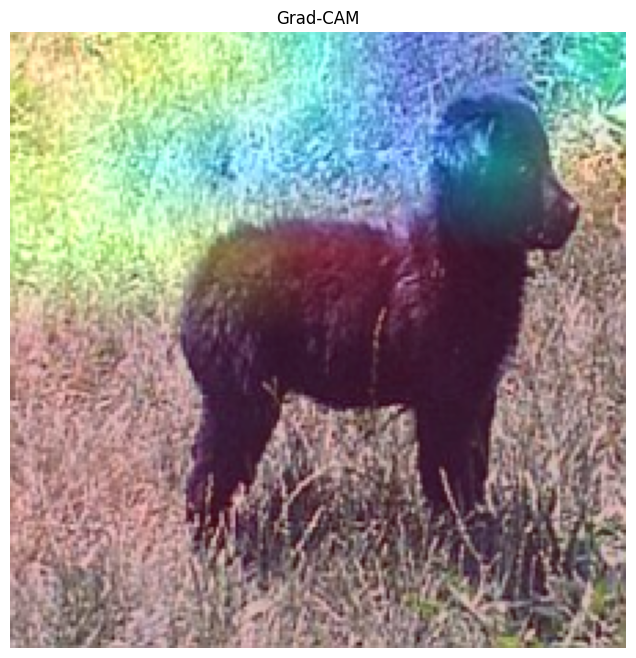

In [17]:
evaluate_model(resnet_scratch, test_loader)

In [18]:
# 사전 학습된 모델 학습 및 평가
print("\nTraining pre-trained ResNet...")
resnet_pretrained = resnet_pretrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_pretrained.parameters(), lr=0.001)
train_model(resnet_pretrained, criterion, optimizer, train_loader, num_epochs=3)


Training pre-trained ResNet...
Epoch 1, Step 294/586 Loss: 0.2288
Epoch 1/3, Loss: 0.1976
Epoch 2, Step 294/586 Loss: 0.1612
Epoch 2/3, Loss: 0.1474
Epoch 3, Step 294/586 Loss: 0.1375
Epoch 3/3, Loss: 0.1267


Accuracy: 93.81%


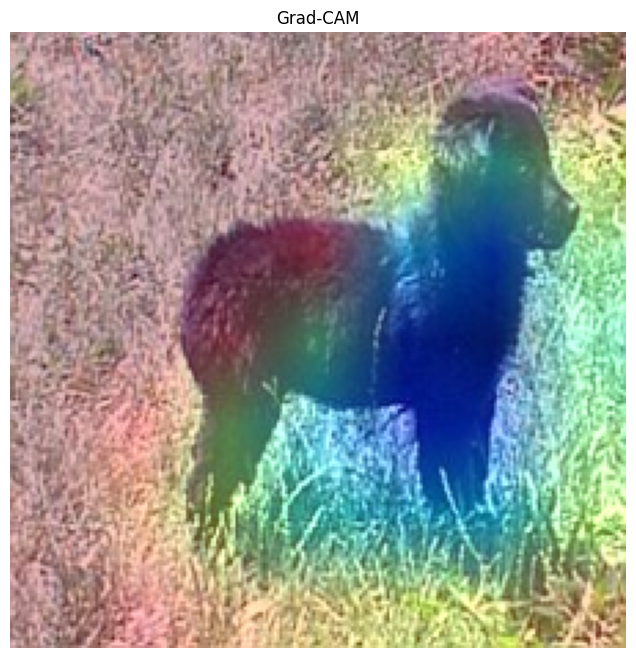

In [19]:
evaluate_model(resnet_pretrained, test_loader)